# To Do:

1. Understand Trapping Simulator [ x ]

2. Implement Dr. Levenson-Falk's ideas [  ]

    - no bursts [x]
    - get rid of bath [x]
        - only trapping and untrapping
    - new trapping dynamics
        - trapping probability time varying
        - switch from low prob to high prob with a slow rate (i.e long time)
        - untrapping rate as function of trapped QP population
    - **Run multiple simulation of the above scenario for various non-markovian models:**
        - correlated and anti-correlated processes with slow rate

3. Test Out New Simulator Against Resonator Simulator [ x ]

4. Refactor Trapping Simulator to work with numba and @jit compilers (i.e. more multithreaded and nice) [  ] 


---

## Trapping Simulator

In [42]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Apr  1 10:04:41 2020

A QP trapping simulator that uses a simplified model:
    

@author: sas
"""
# Imports
#import numpy as np
from numpy import sin, cos, pi, exp, sqrt, zeros, ones, arange, mean, inf, cumsum, array,arctanh
from numpy.random import random, choice, uniform
from math import factorial
from time import perf_counter
import matplotlib.pyplot as plt


class QPtrapper:
    
    def __init__(self,N=1000,Lj=3.6e-11,tauTrap=1e-5,tauRelease=1e-5,tauCommon=1e-4,
                 tauRare=1e-2,tauRecomb=1e-4,sampleRate=300e6,
                 phi=0.4,Delta=2.72370016e-23,T=0.025):

        self.N = int(N) #number of samples (i.e. duration*sample_rate)
                
        """
        poisson paramaters
        """
        # self.Lj = Lj/self.cosd
        self.tauCommon = tauCommon #poisson param for?
        self.tauRare = tauRare #poisson param for cosmic ray events
        self.tauRecomb = tauRecomb #poisson param for qp recombining
        self.tau = tauTrap #poisson param for qp traps
        self.tauR = tauRelease #poisson param for qp release
        
        """
        physical input parameters
        """
        self.sampleRate = sampleRate #sample rate
        self.dt = 1/sampleRate #timesteps
        self.phi = phi #flux bias
        self.Delta = Delta #?
        self.T = T #total time?
        self.de = pi*phi #?
#        if ((phi // 0.5) % 2):
#            self.de += pi
        
        """
        trig calculations
        """
        self.cosd = cos(self.de) 
        self.sind2 = sin(self.de)**2
        self.sin4 = sin(self.de/2)**4
        self.sin2 = sin(self.de/2)**2
        
        """
        fundamental constants
        """
        self.phi0 = 2.06783383*1e-15 #h/2e
        self.kb = 1.38064852e-23
        self.rphi0 = self.phi0/(2*pi) #hbar/2e
        
        """
        physical parameters related to output?
        """
        self.Ne = 8*(self.rphi0**2)/(self.Delta*Lj) #?
        self.Lj0 = Lj #inductance initial?
        self.Lj = Lj/(1-sin(self.de/2)*arctanh(sin(self.de/2))) #inductance?
        # alpha = self.Delta/(4*(self.rphi0**2))
        alpha = self.Delta/(2*(self.rphi0**2)) #?
        self.L1 = alpha*(self.cosd/sqrt(1-self.sin2) + self.sind2/(4*sqrt(1-self.sin2)**3)) #?
        
        """
        simulation start command
        """
        #self._getSwitchingEvents()
        self._getSwitchingEvents_SAS()


    def _dorokhov_boltz(self,tau,Ne=680,delta=2.72370016e-23,de=pi/2,T=0.025):
        return Ne/(tau*sqrt(1-tau)) * exp(-self._Ea(tau,delta,de)/(self.kb*T))
    
    def _Ea(self,tau,delta=2.72370016e-23,de=pi/2):
        return delta*sqrt(1-tau*sin(de/2)**2)
    
    def _MC_doro(self,Ne=680,delta=2.72370016e-23,de=pi/2,T=0.025):
        scale = self._dorokhov_boltz(0.999999999,Ne,delta,de,T)
        while True:
            x = uniform(low=0.0,high=1)
            y = random()*scale
            try:
                if y < self._dorokhov_boltz(x,Ne,delta,de,T):
                    return x
                    break
            except (ZeroDivisionError,RuntimeWarning):
                pass
            
    def _Poisson(self,tau):
        return (self.dt/tau)*exp(-self.dt/tau)
    
    def _getSwitchingEvents(self,):
#        phaseFactor = sin(abs(self.de))
#        pTrap = phaseFactor*self._Poisson(self.tau)
#        pTrap = self._Poisson(self.tau)
#        pRelease = self._Poisson(self.tauR)
#        pCommon = self._Poisson(self.tauCommon)
#        pRare = self._Poisson(self.tauRare)
      
        """
        Constants Defining
        """
        phi0 = self.phi0
        rphi0 = phi0/(2*pi)
        alpha = self.Delta/(2*(rphi0**2))

        """
        Creating Poisson Distribution for the various process
        """
        cs = array([1,2,3,4,5,6,7,8,9],dtype=int) #channels?
        factorials = array([factorial(k) for k in cs],dtype=int) #factorials of cs values
        pR = ((self.dt/self.tauR)**cs)*exp(-self.dt/self.tauR)/factorials #poisson distribution of release
        pT = ((self.dt/self.tau)**cs)*exp(-self.dt/self.tau)/factorials #poisson distribution of trap   
        pCommon = ((self.dt/self.tauCommon)**cs)*exp(-self.dt/self.tauCommon)/factorials #poisson distribution of common
        pRare = ((self.dt/self.tauRare)**cs)*exp(-self.dt/self.tauRare)/factorials #poisson distribution of cosmic
        pRecomb = ((self.dt/self.tauRecomb)**cs)*exp(-self.dt/self.tauRecomb)/factorials #poisson distribution of recombine
        
        """
        Data Structures for storing info from simulation
        """
        trappedChannels = [] #? 
        self.nTrapped = [] #number of trapped QP
        lFreqFactors = [] #?
        # alpha = self.Delta/(4*(rphi0**2))
        self.freqFactors = zeros(self.N) #?
        self.nBulk = list(ones(3)) #3D vector for some reason?
        self.bulkPop = [] #?
        self.burstIndices = [] #?
        
        for n in range(self.N):
            """
            Produce common QP generation events
            """            
            commask = random() < pCommon
            k = cs[commask][-1] if commask.any() else 0
            for _ in range(k):
                self.nBulk.append(1)
                self.nBulk.append(1)
            
            """
            Produce rare QP generation events -- such as cosmic ray bursts
            """
            raremask = random() < pRare
            k = cs[raremask][-1] if raremask.any() else 0
            for _ in range(k):
                self.burstIndices.append(n)
                burst = int(random()*50)
                for i in range(burst):
                    self.nBulk.append(1)
                    self.nBulk.append(1)
            
            """
            Produce pair recombination events
            """
            recombmask = random() < len(self.nBulk)*pRecomb
            k = cs[recombmask][-1] if recombmask.any() else 0
            k = min((k,len(self.nBulk)//2))
            for _ in range(k):
                self.nBulk.remove(1)
                self.nBulk.remove(1)
            
            """        
            Produce trapping events
            """
            trapmask = random() < len(self.nBulk)*pT
            k = cs[trapmask][-1] if trapmask.any() else 0
            k = min((k,len(self.nBulk)))
            for _ in range(k):
                tau = self._MC_doro(self.Ne,self.Delta,self.de,self.T)
                E = self._Ea(tau,self.Delta,self.de)
                trappedChannels.append({'t':tau,'E':E})
                if self.nBulk:
                    self.nBulk.remove(1) 
            
            """                    
            Produce release events
            """
            relmask = random() < len(trappedChannels)*pR
            k = cs[relmask][-1] if relmask.any() else 0
            k = min((k,len(trappedChannels)))
            for _ in range(k):
                ch = choice(trappedChannels)
                trappedChannels.remove(ch)
                self.nBulk.append(1)
            
#           Track changes
            self.nTrapped.append(len(trappedChannels))
            self.bulkPop.append(len(self.nBulk))
            
#           Calculate frequency shift terms for each time point -- Sum_i 1/L_i
            lFreqFactors.append([alpha*c['t']*(self.cosd/sqrt(1-c['t']*self.sin2) + c['t']*self.sind2/(4*sqrt(1-c['t']*self.sin2)**3))for c in trappedChannels])  
            self.freqFactors[n] += sum(lFreqFactors[n])  
        
    def _getSwitchingEvents_SAS(self,):

        """
        Constants Defining
        """
        phi0 = self.phi0
        rphi0 = phi0/(2*pi)
        alpha = self.Delta/(2*(rphi0**2))

        """
        Creating Poisson Distribution for the various process
        """
        cs = array([1,2,3,4,5,6,7,8,9],dtype=int) #channels?
        factorials = array([factorial(k) for k in cs],dtype=int) #factorials of cs values
        pR = ((self.dt/self.tauR)**cs)*exp(-self.dt/self.tauR)/factorials #poisson distribution of release
        pT = ((self.dt/self.tau)**cs)*exp(-self.dt/self.tau)/factorials #poisson distribution of trap   
        pCommon = ((self.dt/self.tauCommon)**cs)*exp(-self.dt/self.tauCommon)/factorials #poisson distribution of common
        pRecomb = ((self.dt/self.tauRecomb)**cs)*exp(-self.dt/self.tauRecomb)/factorials #poisson distribution of recombine
        
        """
        Data Structures for storing info from simulation
        """
        trappedChannels = [] #? 
        self.nTrapped = [] #number of trapped QP
        lFreqFactors = [] #?
        # alpha = self.Delta/(4*(rphi0**2))
        self.freqFactors = zeros(self.N) #?
        self.nGen = [] 
        self.nRel = []
        self.releasePop = []
        self.nGenerated = []
        
        for n in range(self.N):
            """
            Produce common QP generation events
            """            
            commask = random() < pCommon
            k = cs[commask][-1] if commask.any() else 0
            for _ in range(k):
                self.nGen.append(1)
                self.nGen.append(1)
            
            
            """        
            Produce trapping events
            """
            trapmask = random() < len(self.nGen)*pT #this needs updating!!!
            k = cs[trapmask][-1] if trapmask.any() else 0
            k = min((k,len(self.nGen)))
            for _ in range(k):
                tau = self._MC_doro(self.Ne,self.Delta,self.de,self.T)
                E = self._Ea(tau,self.Delta,self.de)
                trappedChannels.append({'t':tau,'E':E})

            
            """                    
            Produce release events
            """
            relmask = random() < len(trappedChannels)*pR
            k = cs[relmask][-1] if relmask.any() else 0
            k = min((k,len(trappedChannels)))
            for _ in range(k):
                ch = choice(trappedChannels)
                trappedChannels.remove(ch)
                self.nRel.append(1)
            
#           Track changes
            self.nTrapped.append(len(trappedChannels))
            self.releasePop.append(len(self.nRel))
            self.nGenerated.append(len(self.nGen))
            
#           Calculate frequency shift terms for each time point -- Sum_i 1/L_i
            lFreqFactors.append([alpha*c['t']*(self.cosd/sqrt(1-c['t']*self.sin2) + c['t']*self.sind2/(4*sqrt(1-c['t']*self.sin2)**3))for c in trappedChannels])  
            self.freqFactors[n] += sum(lFreqFactors[n])  

**Driver Code**

qptrapper runtime: 10.345400330000302 seconds
The average number of trapped QPs is 0.2456


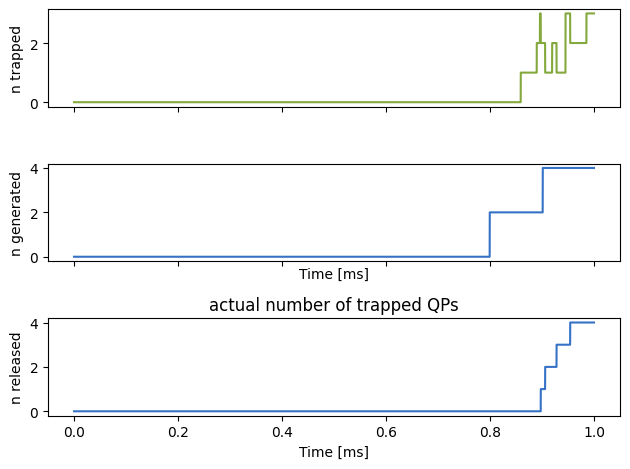

In [45]:
if __name__ == '__main__':
    """
    User Inputs for the simulation
    """
    duration = 1e-3 # seconds to record data
    sampleRate = 300e6
    N = int(duration*sampleRate)
    tauTrap = 140e-6
    tauRelease = 40e-6
    tauCommon = 4e-4
    tauRare = 1e-2
    tauRecomb = 2e-3
    phi = 0.45
    Lj = 21.2e-12
    args = {'N':N,'Lj':Lj,'tauTrap':tauTrap,'tauRelease':tauRelease,'tauCommon':tauCommon,'tauRare':tauRare,
            'tauRecomb':tauRecomb,'sampleRate':sampleRate,
                 'phi':phi,'Delta':2.72370016e-23,'T':0.025}
    
    """
    Driver of the simulation
    """
    now = perf_counter()
    test = QPtrapper(**args) #calling the simulator
    timer = perf_counter()-now
    print('qptrapper runtime: {} seconds'.format(timer))
    print('The average number of trapped QPs is {:.4}'.format(mean(test.nTrapped)))
    
    """
    Makes the plot
    """
    time = arange(N)/sampleRate
    
    h,ax = plt.subplots(3,1,sharex=True)
    ax[0].plot(time*1e3,test.nTrapped,'-g')
    plt.title('actual number of trapped QPs')
    ax[0].set_ylabel('n trapped')
    ax[1].plot(time*1e3,test.nGenerated,'-b')
    ax[1].set_ylabel('n generated')
    ax[1].set_xlabel('Time [ms]')
    ax[2].plot(time*1e3,test.releasePop,'-b')
    ax[2].set_ylabel('n released')
    ax[2].set_xlabel('Time [ms]')
    plt.tight_layout()
    plt.show()

---

## Trapping Simulator (Toy Models)

### Constant $P_t$

In [ ]:
def _getSwitchingEvents_constant_pT(self,):

        """
        Constants Defining
        """
        phi0 = self.phi0
        rphi0 = phi0/(2*pi)
        alpha = self.Delta/(2*(rphi0**2))

        """
        Creating Poisson Distribution for the various process
        """
        cs = array([1,2,3,4,5,6,7,8,9],dtype=int) #channels?
        factorials = array([factorial(k) for k in cs],dtype=int) #factorials of cs values
        pR = ((self.dt/self.tauR)**cs)*exp(-self.dt/self.tauR)/factorials #poisson distribution of release
        pT = ((self.dt/self.tau)**cs)*exp(-self.dt/self.tau)/factorials #poisson distribution of trap   
        pCommon = ((self.dt/self.tauCommon)**cs)*exp(-self.dt/self.tauCommon)/factorials #poisson distribution of common
        pRecomb = ((self.dt/self.tauRecomb)**cs)*exp(-self.dt/self.tauRecomb)/factorials #poisson distribution of recombine
        
        """
        Data Structures for storing info from simulation
        """
        trappedChannels = [] #? 
        self.nTrapped = [] #number of trapped QP
        lFreqFactors = [] #?
        # alpha = self.Delta/(4*(rphi0**2))
        self.freqFactors = zeros(self.N) #?
        self.nGen = [] 
        self.nRel = []
        self.releasePop = []
        self.nGenerated = []
        
        for n in range(self.N):
            """
            Produce common QP generation events
            """            
            commask = random() < pCommon
            k = cs[commask][-1] if commask.any() else 0
            for _ in range(k):
                self.nGen.append(1)
                self.nGen.append(1)
            
            
            """        
            Produce trapping events
            """
            trapmask = random() < len(self.nGen)*pT #constant pT
            k = cs[trapmask][-1] if trapmask.any() else 0
            k = min((k,len(self.nGen)))
            for _ in range(k):
                tau = self._MC_doro(self.Ne,self.Delta,self.de,self.T)
                E = self._Ea(tau,self.Delta,self.de)
                trappedChannels.append({'t':tau,'E':E})

            
            """                    
            Produce release events
            """
            relmask = random() < len(trappedChannels)*pR
            k = cs[relmask][-1] if relmask.any() else 0
            k = min((k,len(trappedChannels)))
            for _ in range(k):
                ch = choice(trappedChannels)
                trappedChannels.remove(ch)
                self.nRel.append(1)
            
#           Track changes
            self.nTrapped.append(len(trappedChannels))
            self.releasePop.append(len(self.nRel))
            self.nGenerated.append(len(self.nGen))
            
#           Calculate frequency shift terms for each time point -- Sum_i 1/L_i
            lFreqFactors.append([alpha*c['t']*(self.cosd/sqrt(1-c['t']*self.sin2) + c['t']*self.sind2/(4*sqrt(1-c['t']*self.sin2)**3))for c in trappedChannels])  
            self.freqFactors[n] += sum(lFreqFactors[n])  

In [ ]:
def _getSwitchingEvents_constant_pT(self,):

        """
        Constants Defining
        """
        phi0 = self.phi0
        rphi0 = phi0/(2*pi)
        alpha = self.Delta/(2*(rphi0**2))

        """
        Creating Poisson Distribution for the various process
        """
        cs = array([1,2,3,4,5,6,7,8,9],dtype=int) #channels?
        factorials = array([factorial(k) for k in cs],dtype=int) #factorials of cs values
        pR = ((self.dt/self.tauR)**cs)*exp(-self.dt/self.tauR)/factorials #poisson distribution of release
        pT = ((self.dt/self.tau)**cs)*exp(-self.dt/self.tau)/factorials #poisson distribution of trap   
        pCommon = ((self.dt/self.tauCommon)**cs)*exp(-self.dt/self.tauCommon)/factorials #poisson distribution of common
        pRecomb = ((self.dt/self.tauRecomb)**cs)*exp(-self.dt/self.tauRecomb)/factorials #poisson distribution of recombine
        
        """
        Data Structures for storing info from simulation
        """
        trappedChannels = [] #? 
        self.nTrapped = [] #number of trapped QP
        lFreqFactors = [] #?
        # alpha = self.Delta/(4*(rphi0**2))
        self.freqFactors = zeros(self.N) #?
        self.nGen = [] 
        self.nRel = []
        self.releasePop = []
        self.nGenerated = []
        
        for n in range(self.N):
            """
            Produce common QP generation events
            """            
            commask = random() < pCommon
            k = cs[commask][-1] if commask.any() else 0
            for _ in range(k):
                self.nGen.append(1)
                self.nGen.append(1)
            
            
            """        
            Produce trapping events
            """
            trapmask = random() < len(self.nGen)*pT #constant pT
            k = cs[trapmask][-1] if trapmask.any() else 0
            k = min((k,len(self.nGen)))
            for _ in range(k):
                tau = self._MC_doro(self.Ne,self.Delta,self.de,self.T)
                E = self._Ea(tau,self.Delta,self.de)
                trappedChannels.append({'t':tau,'E':E})

            
            """                    
            Produce release events
            """
            relmask = random() < len(trappedChannels)*pR
            k = cs[relmask][-1] if relmask.any() else 0
            k = min((k,len(trappedChannels)))
            for _ in range(k):
                ch = choice(trappedChannels)
                trappedChannels.remove(ch)
                self.nRel.append(1)
            
#           Track changes
            self.nTrapped.append(len(trappedChannels))
            self.releasePop.append(len(self.nRel))
            self.nGenerated.append(len(self.nGen))
            
#           Calculate frequency shift terms for each time point -- Sum_i 1/L_i
            lFreqFactors.append([alpha*c['t']*(self.cosd/sqrt(1-c['t']*self.sin2) + c['t']*self.sind2/(4*sqrt(1-c['t']*self.sin2)**3))for c in trappedChannels])  
            self.freqFactors[n] += sum(lFreqFactors[n])  

### Periodic Slow Switch  $P_t(t)$  High-Low State

In [201]:
def create_high_low_state_switch_process(N,sampleUnit=5,fraction=0.1):
    samples = np.ones(N)
    freq = int(N/sampleUnit)
    dist = []
    fraction = 0.2

    samples = samples.reshape(sampleUnit,freq)

    for sample in samples:
        bound = int(fraction*len(sample))
        sample[:bound] = 2

    samples = samples.flatten()
    plt.plot(samples)
    plt.show()
    
def create_high_low_state_switch_stochastic_process(N,sampleUnit=5,fraction=0.1):
    samples = np.ones(N)
    freq = int(N/sampleUnit)
    dist = []

    samples = samples.reshape(sampleUnit,freq)

    for sample in samples:
        bound = int(fraction*len(sample)) + int(rd.uniform(0, rd.uniform(-fraction,fraction)*len(sample)))
        sample[:bound] = 2

    samples = samples.flatten()
    plt.plot(samples)
    plt.show()
    return samples

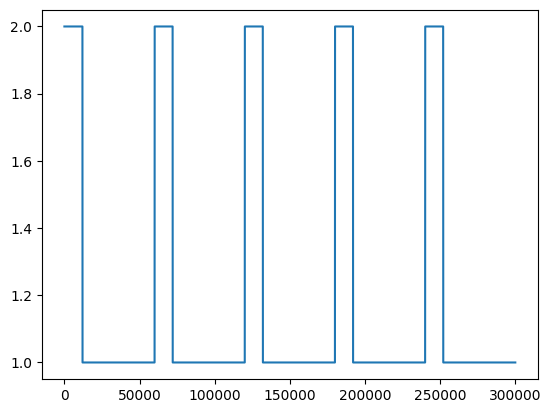

In [194]:
create_high_low_state_switch_process(N,sampleUnit=5,fraction=0.1)

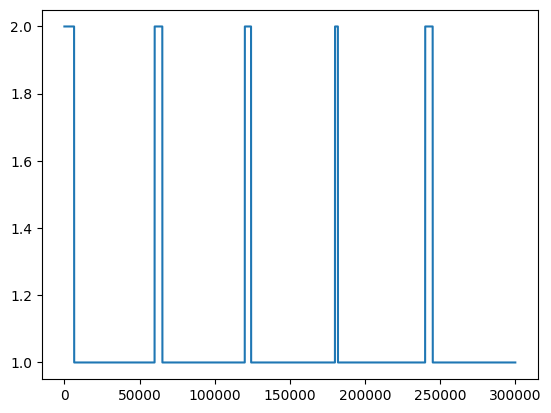

2.0

In [203]:
create_high_low_state_switch_stochastic_process(N,sampleUnit=5,fraction=0.1)

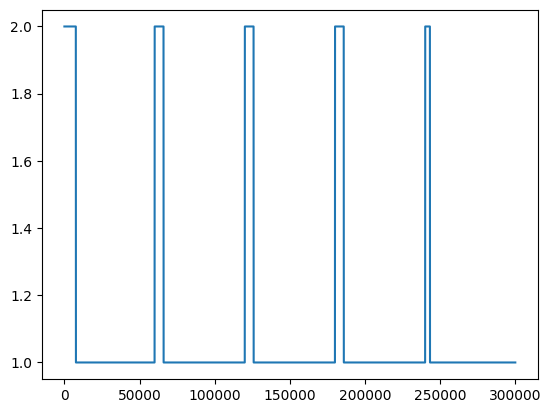

In [206]:
pT = 0.00012
pT_coefficient = create_high_low_state_switch_stochastic_process(N,sampleUnit=5,fraction=0.1)

In [208]:
trapmask = random() < min(5 * pT * pT_coefficient[0], 1)  #periodic_pT

In [213]:
min((2,1))

1

In [199]:
import random as rd

def create_high_low_state_switch_process(N,sampleUnit=5,fraction=0.1):
    samples = np.ones(N)
    freq = int(N/sampleUnit)
    fraction = 0.2

    samples = samples.reshape(sampleUnit,freq)

    for sample in samples:
        bound = int(fraction*len(sample))
        sample[:bound] = 2

    samples = samples.flatten()
    return samples
    
def create_high_low_state_switch_stochastic_process(N,sampleUnit=5,fraction=0.1):
    samples = np.ones(N)
    freq = int(N/sampleUnit)
    
    samples = samples.reshape(sampleUnit,freq)

    for sample in samples:
        bound = int(fraction*len(sample)) + int(rd.uniform(0, rd.uniform(-fraction,fraction)*len(sample)))
        sample[:bound] = 2

    samples = samples.flatten()
    return samples


def _getSwitchingEvents_periodic_pT(self,):

        """
        Constants Defining
        """
        phi0 = self.phi0
        rphi0 = phi0/(2*pi)
        alpha = self.Delta/(2*(rphi0**2))

        """
        Creating Poisson Distribution for the various process
        """
        cs = array([1,2,3,4,5,6,7,8,9],dtype=int) #channels?
        factorials = array([factorial(k) for k in cs],dtype=int) #factorials of cs values
        pR = ((self.dt/self.tauR)**cs)*exp(-self.dt/self.tauR)/factorials #poisson distribution of release
        pT = ((self.dt/self.tau)**cs)*exp(-self.dt/self.tau)/factorials #poisson distribution of trap   
        pCommon = ((self.dt/self.tauCommon)**cs)*exp(-self.dt/self.tauCommon)/factorials #poisson distribution of common
        pRecomb = ((self.dt/self.tauRecomb)**cs)*exp(-self.dt/self.tauRecomb)/factorials #poisson distribution of recombine
        
        """
        Data Structures for storing info from simulation
        """
        trappedChannels = [] #? 
        self.nTrapped = [] #number of trapped QP
        lFreqFactors = [] #?
        # alpha = self.Delta/(4*(rphi0**2))
        self.freqFactors = zeros(self.N) #?
        self.nGen = [] 
        self.nRel = []
        self.releasePop = []
        self.nGenerated = []
        
        pT_coefficient = create_high_low_state_switch_process(N,sampleUnit=10,fraction=0.1)
        
        for n in range(self.N):
            """
            Produce common QP generation events
            """            
            commask = random() < pCommon
            k = cs[commask][-1] if commask.any() else 0
            for _ in range(k):
                self.nGen.append(1)
                self.nGen.append(1)
            
            
            """        
            Produce trapping events
            """
            trapmask = random() < min(len(self.nGen)*pT*pT_coefficient[n], 1) #periodic_pT
            k = cs[trapmask][-1] if trapmask.any() else 0
            k = min((k,len(self.nGen)))
            for _ in range(k):
                tau = self._MC_doro(self.Ne,self.Delta,self.de,self.T)
                E = self._Ea(tau,self.Delta,self.de)
                trappedChannels.append({'t':tau,'E':E})

            
            """                    
            Produce release events
            """
            relmask = random() < len(trappedChannels)*pR
            k = cs[relmask][-1] if relmask.any() else 0
            k = min((k,len(trappedChannels)))
            for _ in range(k):
                ch = choice(trappedChannels)
                trappedChannels.remove(ch)
                self.nRel.append(1)
            
#           Track changes
            self.nTrapped.append(len(trappedChannels))
            self.releasePop.append(len(self.nRel))
            self.nGenerated.append(len(self.nGen))
            
#           Calculate frequency shift terms for each time point -- Sum_i 1/L_i
            lFreqFactors.append([alpha*c['t']*(self.cosd/sqrt(1-c['t']*self.sin2) + c['t']*self.sind2/(4*sqrt(1-c['t']*self.sin2)**3))for c in trappedChannels])  
            self.freqFactors[n] += sum(lFreqFactors[n])  

In [200]:
def _getSwitchingEvents_periodic_stochastic_pT(self,):

        """
        Constants Defining
        """
        phi0 = self.phi0
        rphi0 = phi0/(2*pi)
        alpha = self.Delta/(2*(rphi0**2))

        """
        Creating Poisson Distribution for the various process
        """
        cs = array([1,2,3,4,5,6,7,8,9],dtype=int) #channels?
        factorials = array([factorial(k) for k in cs],dtype=int) #factorials of cs values
        pR = ((self.dt/self.tauR)**cs)*exp(-self.dt/self.tauR)/factorials #poisson distribution of release
        pT = ((self.dt/self.tau)**cs)*exp(-self.dt/self.tau)/factorials #poisson distribution of trap   
        pCommon = ((self.dt/self.tauCommon)**cs)*exp(-self.dt/self.tauCommon)/factorials #poisson distribution of common
        pRecomb = ((self.dt/self.tauRecomb)**cs)*exp(-self.dt/self.tauRecomb)/factorials #poisson distribution of recombine
        
        """
        Data Structures for storing info from simulation
        """
        trappedChannels = [] #? 
        self.nTrapped = [] #number of trapped QP
        lFreqFactors = [] #?
        # alpha = self.Delta/(4*(rphi0**2))
        self.freqFactors = zeros(self.N) #?
        self.nGen = [] 
        self.nRel = []
        self.releasePop = []
        self.nGenerated = []
        
        pT_coefficient = create_high_low_state_switch_stochastic_process(N,sampleUnit=10,fraction=0.1)
        
        for n in range(self.N):
            """
            Produce common QP generation events
            """            
            commask = random() < pCommon
            k = cs[commask][-1] if commask.any() else 0
            for _ in range(k):
                self.nGen.append(1)
                self.nGen.append(1)
            
            
            """        
            Produce trapping events
            """
            trapmask = random() < min(len(self.nGen)*pT*pT_coefficient[n], 1) #periodic_pT
            k = cs[trapmask][-1] if trapmask.any() else 0
            k = min((k,len(self.nGen)))
            for _ in range(k):
                tau = self._MC_doro(self.Ne,self.Delta,self.de,self.T)
                E = self._Ea(tau,self.Delta,self.de)
                trappedChannels.append({'t':tau,'E':E})

            
            """                    
            Produce release events
            """
            relmask = random() < len(trappedChannels)*pR
            k = cs[relmask][-1] if relmask.any() else 0
            k = min((k,len(trappedChannels)))
            for _ in range(k):
                ch = choice(trappedChannels)
                trappedChannels.remove(ch)
                self.nRel.append(1)
            
#           Track changes
            self.nTrapped.append(len(trappedChannels))
            self.releasePop.append(len(self.nRel))
            self.nGenerated.append(len(self.nGen))
            
#           Calculate frequency shift terms for each time point -- Sum_i 1/L_i
            lFreqFactors.append([alpha*c['t']*(self.cosd/sqrt(1-c['t']*self.sin2) + c['t']*self.sind2/(4*sqrt(1-c['t']*self.sin2)**3))for c in trappedChannels])  
            self.freqFactors[n] += sum(lFreqFactors[n])  

### Correlated-Constant $P_t(t)$  

In [ ]:
def _getSwitchingEvents_correlated_constant_pT(self,):
        
        """
        Constants Defining
        """
        factor_increase = 2.0
        phi0 = self.phi0
        rphi0 = phi0/(2*pi)
        alpha = self.Delta/(2*(rphi0**2))

        """
        Creating Poisson Distribution for the various process
        """
        cs = array([1,2,3,4,5,6,7,8,9],dtype=int) #channels?
        factorials = array([factorial(k) for k in cs],dtype=int) #factorials of cs values
        pR = ((self.dt/self.tauR)**cs)*exp(-self.dt/self.tauR)/factorials #poisson distribution of release
        pT = ((self.dt/self.tau)**cs)*exp(-self.dt/self.tau)/factorials #poisson distribution of trap   
        pCommon = ((self.dt/self.tauCommon)**cs)*exp(-self.dt/self.tauCommon)/factorials #poisson distribution of common
        pRecomb = ((self.dt/self.tauRecomb)**cs)*exp(-self.dt/self.tauRecomb)/factorials #poisson distribution of recombine
        
        """
        Data Structures for storing info from simulation
        """
        trappedChannels = [] #? 
        self.nTrapped = [] #number of trapped QP
        lFreqFactors = [] #?
        # alpha = self.Delta/(4*(rphi0**2))
        self.freqFactors = zeros(self.N) #?
        self.nGen = [] 
        self.nRel = []
        self.releasePop = []
        self.nGenerated = []
        
       # pT_coefficient = create_high_low_state_switch_stochastic_process(N,sampleUnit=10,fraction=0.1)
        self.trapped = False
        
        for n in range(self.N):
            
            """
            Produce common QP generation events
            """            
            commask = random() < pCommon
            k = cs[commask][-1] if commask.any() else 0
            for _ in range(k):
                self.nGen.append(1)
                self.nGen.append(1)
            
            
            """        
            Produce trapping events
            """
            if not self.trapped:
                trapmask = random() < len(self.nGen)*pT #constant_pT
            elif self.trapped:
               # trapmask = random() < len(self.nGen)*pT*pT_coefficient[n], 1) #periodic_pT
                trapmask = random() < len(self.nGen)*pT*factor_increase #factor * constant_pT

            k = cs[trapmask][-1] if trapmask.any() else 0
            k = min((k,len(self.nGen)))
            for _ in range(k):
                tau = self._MC_doro(self.Ne,self.Delta,self.de,self.T)
                E = self._Ea(tau,self.Delta,self.de)
                trappedChannels.append({'t':tau,'E':E})
                self.trapped = True
            if k == 0:
                self.trapped = False
            """                    
            Produce release events
            """
            relmask = random() < len(trappedChannels)*pR
            k = cs[relmask][-1] if relmask.any() else 0
            k = min((k,len(trappedChannels)))
            for _ in range(k):
                ch = choice(trappedChannels)
                trappedChannels.remove(ch)
                self.nRel.append(1)
            
#           Track changes
            self.nTrapped.append(len(trappedChannels))
            self.releasePop.append(len(self.nRel))
            self.nGenerated.append(len(self.nGen))
            
#           Calculate frequency shift terms for each time point -- Sum_i 1/L_i
            lFreqFactors.append([alpha*c['t']*(self.cosd/sqrt(1-c['t']*self.sin2) + c['t']*self.sind2/(4*sqrt(1-c['t']*self.sin2)**3))for c in trappedChannels])  
            self.freqFactors[n] += sum(lFreqFactors[n])  

### Correlated-Periodic $P_t(t)$  

In [ ]:
    def _getSwitchingEvents_periodic_correlated_periodic_pT(self, ):
        """
            Constants Defining
            """
        factor_increase = 2.0
        phi0 = self.phi0
        rphi0 = phi0 / (2 * pi)
        alpha = self.Delta / (2 * (rphi0**2))
        """
            Creating Poisson Distribution for the various process
            """
        cs = array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int)  #channels?
        factorials = array([factorial(k) for k in cs],
                           dtype=int)  #factorials of cs values
        pR = ((self.dt / self.tauR)**cs) * exp(
            -self.dt /
            self.tauR) / factorials  #poisson distribution of release
        pT = ((self.dt / self.tau)**cs) * exp(
            -self.dt / self.tau) / factorials  #poisson distribution of trap
        pCommon = ((self.dt / self.tauCommon)**cs) * exp(
            -self.dt /
            self.tauCommon) / factorials  #poisson distribution of common
        pRecomb = ((self.dt / self.tauRecomb)**cs) * exp(
            -self.dt /
            self.tauRecomb) / factorials  #poisson distribution of recombine
        """
            Data Structures for storing info from simulation
            """
        trappedChannels = []  #?
        self.nTrapped = []  #number of trapped QP
        lFreqFactors = []  #?
        # alpha = self.Delta/(4*(rphi0**2))
        self.freqFactors = zeros(self.N)  #?
        self.nGen = []
        self.nRel = []
        self.releasePop = []
        self.nGenerated = []

        pT_coefficient = create_high_low_state_switch_process(N,sampleUnit=10,fraction=0.1)
        self.trapped = False

        for n in range(self.N):
            """
                Produce common QP generation events
                """
            commask = random() < pCommon
            k = cs[commask][-1] if commask.any() else 0
            for _ in range(k):
                self.nGen.append(1)
                self.nGen.append(1)
            """        
                Produce trapping events
                """
            if not self.trapped:
                trapmask = random() < len(self.nGen)*pT*pT_coefficient[n] #periodic_pT
            elif self.trapped:
                trapmask = random() < len(
                    self.nGen) * pT * factor_increase  #factor * constant_pT

            k = cs[trapmask][-1] if trapmask.any() else 0
            k = min((k, len(self.nGen)))
            for _ in range(k):
                tau = self._MC_doro(self.Ne, self.Delta, self.de, self.T)
                E = self._Ea(tau, self.Delta, self.de)
                trappedChannels.append({'t': tau, 'E': E})
                self.trapped = True
            if k == 0:
                self.trapped = False
            """                    
                Produce release events
                """
            relmask = random() < len(trappedChannels) * pR
            k = cs[relmask][-1] if relmask.any() else 0
            k = min((k, len(trappedChannels)))
            for _ in range(k):
                ch = choice(trappedChannels)
                trappedChannels.remove(ch)
                self.nRel.append(1)

    #           Track changes
            self.nTrapped.append(len(trappedChannels))
            self.releasePop.append(len(self.nRel))
            self.nGenerated.append(len(self.nGen))

            #           Calculate frequency shift terms for each time point -- Sum_i 1/L_i
            lFreqFactors.append([
                alpha * c['t'] *
                (self.cosd / sqrt(1 - c['t'] * self.sin2) +
                 c['t'] * self.sind2 / (4 * sqrt(1 - c['t'] * self.sin2)**3))
                for c in trappedChannels
            ])
            self.freqFactors[n] += sum(lFreqFactors[n])



### Correlated-Stochastic-Periodic $P_t(t)$  

In [ ]:
    def _getSwitchingEvents_periodic_correlated_periodic_stochastic_pT(self, ):
        """
            Constants Defining
            """
        factor_increase = 2.0
        phi0 = self.phi0
        rphi0 = phi0 / (2 * pi)
        alpha = self.Delta / (2 * (rphi0**2))
        """
            Creating Poisson Distribution for the various process
            """
        cs = array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int)  #channels?
        factorials = array([factorial(k) for k in cs],
                           dtype=int)  #factorials of cs values
        pR = ((self.dt / self.tauR)**cs) * exp(
            -self.dt /
            self.tauR) / factorials  #poisson distribution of release
        pT = ((self.dt / self.tau)**cs) * exp(
            -self.dt / self.tau) / factorials  #poisson distribution of trap
        pCommon = ((self.dt / self.tauCommon)**cs) * exp(
            -self.dt /
            self.tauCommon) / factorials  #poisson distribution of common
        pRecomb = ((self.dt / self.tauRecomb)**cs) * exp(
            -self.dt /
            self.tauRecomb) / factorials  #poisson distribution of recombine
        """
            Data Structures for storing info from simulation
            """
        trappedChannels = []  #?
        self.nTrapped = []  #number of trapped QP
        lFreqFactors = []  #?
        # alpha = self.Delta/(4*(rphi0**2))
        self.freqFactors = zeros(self.N)  #?
        self.nGen = []
        self.nRel = []
        self.releasePop = []
        self.nGenerated = []

        pT_coefficient = create_high_low_state_switch_stochastic_process(N,sampleUnit=10,fraction=0.1)
        self.trapped = False

        for n in range(self.N):
            """
                Produce common QP generation events
                """
            commask = random() < pCommon
            k = cs[commask][-1] if commask.any() else 0
            for _ in range(k):
                self.nGen.append(1)
                self.nGen.append(1)
            """        
                Produce trapping events
                """
            if not self.trapped:
                trapmask = random() < len(self.nGen)*pT*pT_coefficient[n] #periodic_pT
            elif self.trapped:
                trapmask = random() < len(
                    self.nGen) * pT * factor_increase  #factor * constant_pT

            k = cs[trapmask][-1] if trapmask.any() else 0
            k = min((k, len(self.nGen)))
            for _ in range(k):
                tau = self._MC_doro(self.Ne, self.Delta, self.de, self.T)
                E = self._Ea(tau, self.Delta, self.de)
                trappedChannels.append({'t': tau, 'E': E})
                self.trapped = True
            if k == 0:
                self.trapped = False
            """                    
                Produce release events
                """
            relmask = random() < len(trappedChannels) * pR
            k = cs[relmask][-1] if relmask.any() else 0
            k = min((k, len(trappedChannels)))
            for _ in range(k):
                ch = choice(trappedChannels)
                trappedChannels.remove(ch)
                self.nRel.append(1)

    #           Track changes
            self.nTrapped.append(len(trappedChannels))
            self.releasePop.append(len(self.nRel))
            self.nGenerated.append(len(self.nGen))

            #           Calculate frequency shift terms for each time point -- Sum_i 1/L_i
            lFreqFactors.append([
                alpha * c['t'] *
                (self.cosd / sqrt(1 - c['t'] * self.sin2) +
                 c['t'] * self.sind2 / (4 * sqrt(1 - c['t'] * self.sin2)**3))
                for c in trappedChannels
            ])
            self.freqFactors[n] += sum(lFreqFactors[n])



## Trapping Simulator Refactored [v 2.0]

In [21]:
import numpy as np
from numpy.random import random, choice, uniform
from numba import njit, vectorize, int64, float64
from math import lgamma, exp, pow, sqrt, log, pi


SQRT2PI = sqrt(2.0 * pi)


@vectorize([float64(int64, int64)], fastmath=True)
def binom(n, k):
    return exp(lgamma(n + 1) - lgamma(k + 1) - lgamma(n - k + 1))

@vectorize([float64(int64, float64)], fastmath=True)
def poisson(k, mu):
    return exp(k * log(mu) - mu - lgamma(k + 1))

@vectorize([float64(float64, float64, float64)], fastmath=True)
def normal_pdf(x, mean=0, std_deviation=1):
    u = (x - mean) / std_deviation
    return exp(-0.5 * u ** 2) / (SQRT2PI * std_deviation)

In [110]:
def simulateTrappingDynamics():
    nGenerated = []
    nBulk = []
    nTrapped = []
    nReleased = []
    nAnnhilated = []

    for t in time_range:
        """
        first event
        """
        if t == 1:
            nBulk.append(0)
            nTrapped.append(0)
        
        """
        generate QPs
        """
        qp_generated_common = generate_qp(tauCommon,k)
        qp_generated_cosmic = generate_qp(tauCosmic,k)
        qp_generated = qp_generated_common + qp_generated_cosmic
        
        """
        add generated QP stay to bulk
        """
        qp_bulk = nBulk[t - 1] + qp_generated
        
        """
        annhilate QPs from bulk from previous time step
        """
        qp_recombined = recombine_qp(annhilation_process(), nBulk[t - 1])
        
        """
        remove qp from bulk that recombined
        """
        qp_bulk = qp_bulk - qp_recombined
        
        """
        Trap QPs
        """
        qp_trapped = trap_qp(trapping_process(), qp_bulk) + nTrapped[t - 1]
        
        """
        Release QPs
        """
        qp_untrapped = release_qp(release_process(), nTrapped[t - 1])
        
        """
        Update the number of trapped QP
        """
        qp_trapped = qp_trapped - qp_untrapped
        
        """
        Update QP number in bulk
        """
        qp_bulk = qp_bulk - qp_trapped
        
        """
        store values to disc
        """
        nGenerated.append(qp_generated)
        nAnnhilated.append(qp_recombined)
        nTrapped.append(qp_trapped)
        nReleased.append(qp_untrapped)
        nBulk.append(qp_bulk)
        
        """
        Calculate Shift In Frequency
        """
        measure_frequency_shift()

In [ ]:
def getSwitchingEvents():
    """
    Constants Defining
    """
    phi0 = phi0
    rphi0 = phi0 / (2 * pi)
    alpha = Delta / (2 * (rphi0**2))
    """
    Creating Poisson Distribution for the various process
    """
    cs = array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int)  #channels?
    factorials = array([factorial(k) for k in cs],
                       dtype=int)  #factorials of cs values
    pR = ((dt / tauR)**cs) * exp(
        -dt / tauR) / factorials  #poisson distribution of release
    pT = ((dt / tau)**cs) * exp(
        -dt / tau) / factorials  #poisson distribution of trap
    pCommon = ((dt / tauCommon)**cs) * exp(
        -dt / tauCommon) / factorials  #poisson distribution of common
    pRare = ((dt / tauRare)**cs) * exp(
        -dt / tauRare) / factorials  #poisson distribution of cosmic
    pRecomb = ((dt / tauRecomb)**cs) * exp(
        -dt / tauRecomb) / factorials  #poisson distribution of recombine
    """
    Data Structures for storing info from simulation
    """
    trappedChannels = []  #?
    nTrapped = []  #number of trapped QP
    lFreqFactors = []  #?
    # alpha = Delta/(4*(rphi0**2))
    freqFactors = zeros(N)  #?
    nBulk = list(ones(3))  #3D vector for some reason?
    bulkPop = []  #?
    burstIndices = []  #?

    for n in range(N):
        """
        Produce common QP generation events
        """
        commask = random() < pCommon
        k = cs[commask][-1] if commask.any() else 0
        for _ in range(k):
            nBulk.append(1)
            nBulk.append(1)
            """
            Produce rare QP generation events -- such as cosmic ray bursts
            """
            raremask = random() < pRare
            k = cs[raremask][-1] if raremask.any() else 0
            for _ in range(k):
                burstIndices.append(n)
                burst = int(random() * 50)
                for i in range(burst):
                    nBulk.append(1)
                    nBulk.append(1)
            """
            Produce pair recombination events
            """
            recombmask = random() < len(nBulk) * pRecomb
            k = cs[recombmask][-1] if recombmask.any() else 0
            k = min((k, len(nBulk) // 2))
            for _ in range(k):
                nBulk.remove(1)
                nBulk.remove(1)
            """        
            Produce trapping events
            """
            trapmask = random() < len(nBulk) * pT
            k = cs[trapmask][-1] if trapmask.any() else 0
            k = min((k, len(nBulk)))
            for _ in range(k):
                tau = _MC_doro(Ne, Delta, de, T)
                E = _Ea(tau, Delta, de)
                trappedChannels.append({'t': tau, 'E': E})
                if nBulk:
                    nBulk.remove(1)
            """                    
            Produce release events
            """
            relmask = random() < len(trappedChannels) * pR
            k = cs[relmask][-1] if relmask.any() else 0
            k = min((k, len(trappedChannels)))
            for _ in range(k):
                ch = choice(trappedChannels)
                trappedChannels.remove(ch)
                nBulk.append(1)


#           Track changes
nTrapped.append(len(trappedChannels))
bulkPop.append(len(nBulk))

#           Calculate frequency shift terms for each time point -- Sum_i 1/L_i
lFreqFactors.append([
    alpha * c['t'] * (cosd / sqrt(1 - c['t'] * sin2) + c['t'] * sind2 /
                      (4 * sqrt(1 - c['t'] * sin2)**3))
    for c in trappedChannels
])
freqFactors[n] += sum(lFreqFactors[n])


In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Apr  1 10:04:41 2020

A QP trapping simulator that uses a simplified model:
    

@author: sas
"""
# Imports
#import numpy as np
from numpy import sin, cos, pi, exp, sqrt, zeros, ones, arange, mean, inf, cumsum, array,arctanh
from numpy.random import random, choice, uniform
from math import factorial
from time import perf_counter
import matplotlib.pyplot as plt


class QPtrapper:
    
    def __init__(self,N=1000,Lj=3.6e-11,tauTrap=1e-5,tauRelease=1e-5,tauCommon=1e-4,
                 tauRare=1e-2,tauRecomb=1e-4,sampleRate=300e6,
                 phi=0.4,Delta=2.72370016e-23,T=0.025):

        self.N = int(N) #number of samples (i.e. duration*sample_rate)
                
        """
        poisson paramaters
        """
        # self.Lj = Lj/self.cosd
        self.tauCommon = tauCommon #poisson param for?
        self.tauRare = tauRare #poisson param for cosmic ray events
        self.tauRecomb = tauRecomb #poisson param for qp recombining
        self.tau = tauTrap #poisson param for qp traps
        self.tauR = tauRelease #poisson param for qp release
        
        """
        physical input parameters
        """
        self.sampleRate = sampleRate #sample rate
        self.dt = 1/sampleRate #timesteps
        self.phi = phi #flux bias
        self.Delta = Delta #?
        self.T = T #total time?
        self.de = pi*phi #?
#        if ((phi // 0.5) % 2):
#            self.de += pi
        
        """
        trig calculations
        """
        self.cosd = cos(self.de) 
        self.sind2 = sin(self.de)**2
        self.sin4 = sin(self.de/2)**4
        self.sin2 = sin(self.de/2)**2
        
        """
        fundamental constants
        """
        self.phi0 = 2.06783383*1e-15 #h/2e
        self.kb = 1.38064852e-23
        self.rphi0 = self.phi0/(2*pi) #hbar/2e
        
        """
        physical parameters related to output?
        """
        self.Ne = 8*(self.rphi0**2)/(self.Delta*Lj) #?
        self.Lj0 = Lj #inductance initial?
        self.Lj = Lj/(1-sin(self.de/2)*arctanh(sin(self.de/2))) #inductance?
        # alpha = self.Delta/(4*(self.rphi0**2))
        alpha = self.Delta/(2*(self.rphi0**2)) #?
        self.L1 = alpha*(self.cosd/sqrt(1-self.sin2) + self.sind2/(4*sqrt(1-self.sin2)**3)) #?
        
        """
        simulation start command
        """
        self._getSwitchingEvents()


    def _dorokhov_boltz(self,tau,Ne=680,delta=2.72370016e-23,de=pi/2,T=0.025):
        return Ne/(tau*sqrt(1-tau)) * exp(-self._Ea(tau,delta,de)/(self.kb*T))
    
    def _Ea(self,tau,delta=2.72370016e-23,de=pi/2):
        return delta*sqrt(1-tau*sin(de/2)**2)
    
    def _MC_doro(self,Ne=680,delta=2.72370016e-23,de=pi/2,T=0.025):
        scale = self._dorokhov_boltz(0.999999999,Ne,delta,de,T)
        while True:
            x = uniform(low=0.0,high=1)
            y = random()*scale
            try:
                if y < self._dorokhov_boltz(x,Ne,delta,de,T):
                    return x
                    break
            except (ZeroDivisionError,RuntimeWarning):
                pass
            
    def _Poisson(self,tau):
        return (self.dt/tau)*exp(-self.dt/tau)
    
    def _getSwitchingEvents(self,):
#        phaseFactor = sin(abs(self.de))
#        pTrap = phaseFactor*self._Poisson(self.tau)
#        pTrap = self._Poisson(self.tau)
#        pRelease = self._Poisson(self.tauR)
#        pCommon = self._Poisson(self.tauCommon)
#        pRare = self._Poisson(self.tauRare)
      
        """
        Constants Defining
        """
        phi0 = self.phi0
        rphi0 = phi0/(2*pi)
        alpha = self.Delta/(2*(rphi0**2))

        """
        Creating Poisson Distribution for the various process
        """
        cs = array([1,2,3,4,5,6,7,8,9],dtype=int) #channels?
        factorials = array([factorial(k) for k in cs],dtype=int) #factorials of cs values
        pR = ((self.dt/self.tauR)**cs)*exp(-self.dt/self.tauR)/factorials #poisson distribution of release
        pT = ((self.dt/self.tau)**cs)*exp(-self.dt/self.tau)/factorials #poisson distribution of trap   
        pCommon = ((self.dt/self.tauCommon)**cs)*exp(-self.dt/self.tauCommon)/factorials #poisson distribution of common
        pRare = ((self.dt/self.tauRare)**cs)*exp(-self.dt/self.tauRare)/factorials #poisson distribution of cosmic
        pRecomb = ((self.dt/self.tauRecomb)**cs)*exp(-self.dt/self.tauRecomb)/factorials #poisson distribution of recombine
        
        """
        Data Structures for storing info from simulation
        """
        trappedChannels = [] #? 
        self.nTrapped = [] #number of trapped QP
        lFreqFactors = [] #?
        # alpha = self.Delta/(4*(rphi0**2))
        self.freqFactors = zeros(self.N) #?
        self.nBulk = list(ones(3)) #3D vector for some reason?
        self.bulkPop = [] #?
        self.burstIndices = [] #?
        
        for n in range(self.N):
            """
            Produce common QP generation events
            """            
            commask = random() < pCommon
            k = cs[commask][-1] if commask.any() else 0
            for _ in range(k):
                self.nBulk.append(1)
                self.nBulk.append(1)
            
            """
            Produce rare QP generation events -- such as cosmic ray bursts
            """
            raremask = random() < pRare
            k = cs[raremask][-1] if raremask.any() else 0
            for _ in range(k):
                self.burstIndices.append(n)
                burst = int(random()*50)
                for i in range(burst):
                    self.nBulk.append(1)
                    self.nBulk.append(1)
            
            """
            Produce pair recombination events
            """
            recombmask = random() < len(self.nBulk)*pRecomb
            k = cs[recombmask][-1] if recombmask.any() else 0
            k = min((k,len(self.nBulk)//2))
            for _ in range(k):
                self.nBulk.remove(1)
                self.nBulk.remove(1)
            
            """        
            Produce trapping events
            """
            trapmask = random() < len(self.nBulk)*pT
            k = cs[trapmask][-1] if trapmask.any() else 0
            k = min((k,len(self.nBulk)))
            for _ in range(k):
                tau = self._MC_doro(self.Ne,self.Delta,self.de,self.T)
                E = self._Ea(tau,self.Delta,self.de)
                trappedChannels.append({'t':tau,'E':E})
                if self.nBulk:
                    self.nBulk.remove(1) 
            
            """                    
            Produce release events
            """
            relmask = random() < len(trappedChannels)*pR
            k = cs[relmask][-1] if relmask.any() else 0
            k = min((k,len(trappedChannels)))
            for _ in range(k):
                ch = choice(trappedChannels)
                trappedChannels.remove(ch)
                self.nBulk.append(1)
            
#           Track changes
            self.nTrapped.append(len(trappedChannels))
            self.bulkPop.append(len(self.nBulk))
            
#           Calculate frequency shift terms for each time point -- Sum_i 1/L_i
            lFreqFactors.append([alpha*c['t']*(self.cosd/sqrt(1-c['t']*self.sin2) + c['t']*self.sind2/(4*sqrt(1-c['t']*self.sin2)**3))for c in trappedChannels])  
            self.freqFactors[n] += sum(lFreqFactors[n])  

Driver Code

In [ ]:
if __name__ == '__main__':
    """
    User Inputs for the simulation
    """
    duration = 1e-3 # seconds to record data
    sampleRate = 300e6
    N = int(duration*sampleRate)
    tauTrap = 140e-6
    tauRelease = 40e-6
    tauCommon = 4e-4
    tauRare = 1e-2
    tauRecomb = 2e-3
    phi = 0.45
    Lj = 21.2e-12
    args = {'N':N,'Lj':Lj,'tauTrap':tauTrap,'tauRelease':tauRelease,'tauCommon':tauCommon,'tauRare':tauRare,
            'tauRecomb':tauRecomb,'sampleRate':sampleRate,
                 'phi':phi,'Delta':2.72370016e-23,'T':0.025}
    
    """
    Driver of the simulation
    """
    now = perf_counter()
    test = QPtrapper(**args) #calling the simulator
    timer = perf_counter()-now
    print('qptrapper runtime: {} seconds'.format(timer))
    print('The average number of trapped QPs is {:.4}'.format(mean(test.nTrapped)))
    
    """
    Makes the plot
    """
    time = arange(N)/sampleRate
    
    h,ax = plt.subplots(2,1,sharex=True)
    ax[0].plot(time*1e3,test.nTrapped,'-g')
    plt.title('actual number of trapped QPs')
    ax[0].set_ylabel('n trapped')
    ax[1].plot(time*1e3,test.bulkPop,'-b')
    ax[1].set_ylabel('number in bulk')
    ax[1].set_xlabel('Time [ms]')
    plt.show()

## Resonator Simulator

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Apr  2 12:50:59 2020

@author: sas
"""
from time import perf_counter
import matplotlib.pyplot as plt
from fitTools.Resonator import Resonator
import numpy as np
from scipy.signal import butter,lfilter


class NBResonator():
    
    def __init__(self,trapper,L=1e-9,C=0.7e-12,photonRO=1,photonNoise=0.5,Qi=5e4,Qe=5e4,sampleRate=300e6,delKappa = -0.5,fd=None):
        self.port1 = Resonator('R')
        self.N = trapper.N
        self.Lj0 = trapper.Lj0
        self.Lj = trapper.Lj
        self.f0 = 1/(2*np.pi*np.sqrt((L + self.Lj)*C))
        self.q0 = self.Lj/(L+self.Lj)
        self.photonRO = photonRO
        self.Qi = Qi
        self.Qe = Qe
        self.Qt = Qi*Qe / (Qi + Qe)
        self.sampleRate = sampleRate
        self.kappa = 2*np.pi*self.f0/self.Qt
        self.kappa_e = 2*np.pi*self.f0/self.Qe
        self.fwhm = self.f0/self.Qt
        self.diameter = 2*self.Qt/self.Qe
        self.f = self.f0 + delKappa*self.kappa/(2*np.pi) # the resonator drive frequency for measurement
        if fd != None:
            self.f = fd
        self.f_form = self.f0 - (self.q0*self.f0*self.Lj*np.array(trapper.freqFactors)/2)
        self.f_shift = self.q0*self.f0*self.Lj*trapper.L1/2
#        self.SNR = photonRO*self.kappa/(4*sampleRate)*(1 - 4*self.Qt/self.Qe * (1-self.Qt/self.Qe))
        self.pSNR = photonRO*self.kappa**2/(4*self.kappa_e*(0.5+photonNoise)*sampleRate)
        self.pSNRdB = 10*np.log10(self.pSNR)
        
#        self.sigma = self.diameter/(2*np.sqrt(2*self.SNR))
        self.sigma = 1/np.sqrt(self.pSNR)
        self.complex_noise = np.empty(self.N,dtype=complex)
        self.complex_noise.real = np.random.normal(scale = self.sigma,size=self.N)
        self.complex_noise.imag = np.random.normal(scale = self.sigma,size=self.N)
#        self.complex_noise = np.array(
#                [np.random.normal() * np.exp(1j*np.random.uniform(low=0,high=2*np.pi)) for i in range(self.N)
#                ])
        #get the response at given frequency
#        self._get_clean_response(self.w)
        kwargs = dict(fr = self.f_form,
                      Ql = self.Qt,
                      Qc = self.Qe,
                      a = 1.,
                      alpha = 0.,
                      delay = 0.)
        signal = self.port1._S11_directrefl(self.f,**kwargs)
        self.signal = self.butter_lowpass_filter(signal - signal[0],self.kappa,self.sampleRate)+signal[0]
        self.signal += self.complex_noise
#        self.signal = self.port1._S11_directrefl(self.f,**kwargs)
        self.dParams = {'fd': self.f,
                        'f0': self.f0,
                        'Qt': self.Qt,
                        'Qi': self.Qi,
                        'Qe': self.Qe,
                        'N': self.N,
                        'q': self.q0,
                        'photonRO': self.photonRO,
                        'sampleRate': self.sampleRate,
                        'kappa': self.kappa,
                        'fwhm': self.fwhm,
                        'diameter': self.diameter,
                        'freq_shift': self.f_shift,
                        'SNR': self.pSNR,
                        'SNRdB': self.pSNRdB,
                        'sigma': self.sigma}
        
    def butter_lowpass(self,cutoff, fs, order=1):
        nyq = 0.5 * fs
        normal_cutoff = cutoff / nyq
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        return b, a
    
    def butter_lowpass_filter(self,data, cutoff, fs, order=1):
        b, a = self.butter_lowpass(cutoff, fs, order=order)
        y = lfilter(b, a, data)
        return y

**Driver Code**

qptrapper runtime: 22.648129304999202 seconds
The average number of trapped QPs is 0.4152
Resonator runtime: 0.08410090999950626


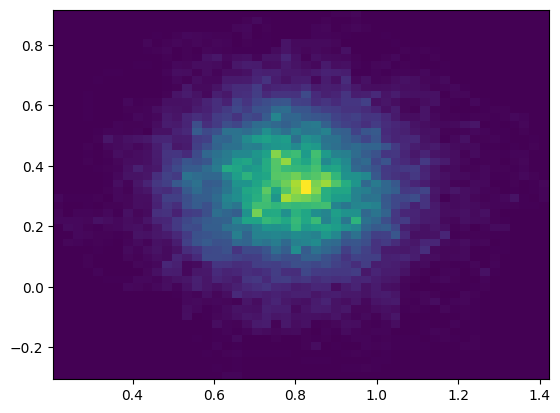

In [47]:
#import QPtrapper

if __name__ == '__main__':
    
    
    duration = 1e-3 # seconds to record data
    sampleRate = 300e6
    N = int(duration*sampleRate)
    tauTrap = 140e-6
    tauRelease = 40e-6
    tauCommon = 4e-4
    tauRare = 1e-2
    tauRecomb = 2e-3
    phi = 0.45
    Lj = 21.2e-12
    L = 1.89e-9
    C = 0.2776e-12
    Qi = 6000
    Qe = 500
    photonRO = 2
    delKappa = -0.1
    
    args = {'N':N,'Lj':Lj,'tauTrap':tauTrap,'tauRelease':tauRelease,'tauCommon':tauCommon,'tauRare':tauRare,
            'tauRecomb':tauRecomb,'sampleRate':sampleRate,
                 'phi':phi,'Delta':2.72370016e-23,'T':0.025}
    
    now = perf_counter()
    test = QPtrapper(**args)
    timer = perf_counter()-now
    print('qptrapper runtime: {} seconds'.format(timer))
    print('The average number of trapped QPs is {:.4}'.format(np.mean(test.nTrapped)))
    
    
    now2 = perf_counter()
    resArgs = {'L':L,'C':C,'photonRO':photonRO,'Qi':Qi,'Qe':Qe,'sampleRate':sampleRate,'delKappa':delKappa}
    res = NBResonator(test,**resArgs)
    duration2 = perf_counter() - now2
    print('Resonator runtime: {}'.format(duration2))
    
    avgTime = 4*res.Qt*50/(photonRO*2*np.pi*res.f0)
    nAvg = int(max(avgTime*sampleRate,1))
    from scipy.signal import windows,convolve
    window = windows.hann(nAvg)
    rhann = convolve(res.signal.real,window,mode='same')/sum(window)
    ihann = convolve(res.signal.imag,window,mode='same')/sum(window)
    
    plt.hist2d(rhann,ihann,bins=(50,50));plt.show()
    
    time = np.arange(N)/sampleRate
    plt.show()
    
#    kwargs = dict(fr = res.f0,
#                  Ql = res.Qt,
#                  Qc = Qe,
#                  a = 1.,
#                  alpha = 0.,
#                  delay = 0.)
#    freq = np.linspace(res.f0-2*res.gamma/np.pi,res.f0+2*res.gamma/np.pi,3000)
#    S11 = res.complex_noise + res.port1._S11_directrefl(freq,**kwargs)
#    res.port1.add_data(freq,S11)
#    plt.rcParams["figure.figsize"] = [10,5]
#    port1.plotrawdata()
#    f0 = res.f_form*1e-9
#    f = res.f * 1e-9
#    
#    signal = res.signal.real
#    
#    time = np.arange(N)/sampleRate
#    
#    fig, axs = plt.subplots(4, 1, constrained_layout=True,figsize=[12,12])
#    axs[0].plot(time, f0, '.r')
#    axs[0].set_title('resonant frequency')
#    axs[0].set_ylabel('f0 [GHz]')
#    axs[1].plot(time,signal,'.b')
#    axs[1].set_title('real resonse at {:.7} GHz'.format(f))
#    axs[1].set_ylabel('Re[S11]')
#    axs[2].plot(time,test.nTrapped,'-g')
#    axs[2].set_title('actual number of trapped QPs')
#    axs[2].set_ylabel('n trapped')
#    axs[2].set_xlabel('Time [s]')
#    hist = axs[3].hist(signal,bins=50,density=True)
#    axs[3].set_title('Histogram of Re[S11] at {:.7} GHz'.format(f))
#    axs[3].set_xlabel('Re[S11]')
#    axs[3].set_ylabel('p(Re[S11])')
#    fig.suptitle('QP trapping simulator',fontsize=16)
#    print('The average number of trapped QPs is {:.4}'.format(np.mean(test.nTrapped)))

From pickle

In [11]:
import dill

qp_trapper_obj = dill.load(open("results/hpc_1/qp_trapper_short_run_periodic_stochastic_2022_04_12-12_00_14_AM.pickle", "rb"))

qptrapper runtime: 4.73000000056345e-07 seconds
The average number of trapped QPs is 8.673
Resonator runtime: 0.4781413789999647


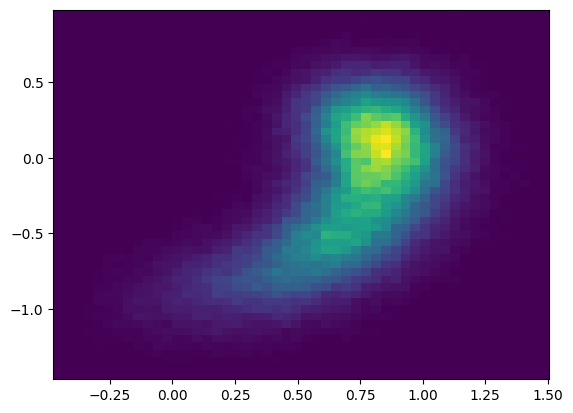

In [10]:
if __name__ == '__main__':
    
    
    duration = 1e-3 # seconds to record data
    sampleRate = 300e6
    N = int(duration*sampleRate)
    tauTrap = 140e-6
    tauRelease = 40e-6
    tauCommon = 4e-4
    tauRare = 1e-2
    tauRecomb = 2e-3
    phi = 0.45
    Lj = 21.2e-12
    L = 1.89e-9
    C = 0.2776e-12
    Qi = 6000
    Qe = 500
    photonRO = 2
    delKappa = -0.1
    
    args = {'N':N,'Lj':Lj,'tauTrap':tauTrap,'tauRelease':tauRelease,'tauCommon':tauCommon,'tauRare':tauRare,
            'tauRecomb':tauRecomb,'sampleRate':sampleRate,
                 'phi':phi,'Delta':2.72370016e-23,'T':0.025}
    
    now = perf_counter()
    test = qp_trapper_obj
    timer = perf_counter()-now
    print('qptrapper runtime: {} seconds'.format(timer))
    print('The average number of trapped QPs is {:.4}'.format(np.mean(test.nTrapped)))
    
    
    now2 = perf_counter()
    resArgs = {'L':L,'C':C,'photonRO':photonRO,'Qi':Qi,'Qe':Qe,'sampleRate':sampleRate,'delKappa':delKappa}
    res = NBResonator(test,**resArgs)
    duration2 = perf_counter() - now2
    print('Resonator runtime: {}'.format(duration2))
    
    avgTime = 4*res.Qt*50/(photonRO*2*np.pi*res.f0)
    nAvg = int(max(avgTime*sampleRate,1))
    from scipy.signal import windows,convolve
    window = windows.hann(nAvg)
    rhann = convolve(res.signal.real,window,mode='same')/sum(window)
    ihann = convolve(res.signal.imag,window,mode='same')/sum(window)
    
    plt.hist2d(rhann,ihann,bins=(50,50))
    
    time = np.arange(N)/sampleRate
    plt.savefig("nb_resonator_short_run_periodic_stochastic_2022_04_12-12_32_38_AM.png")
    plt.show()

# Code for HPC